# Pandas alternatives?
Dask, Ray, Modin, Vaex... Lets see how they stack up!

## Quick Compare Guide
Reference: https://www.datarevenue.com/en-blog/pandas-vs-dask-vs-vaex-vs-modin-vs-rapids-vs-ray
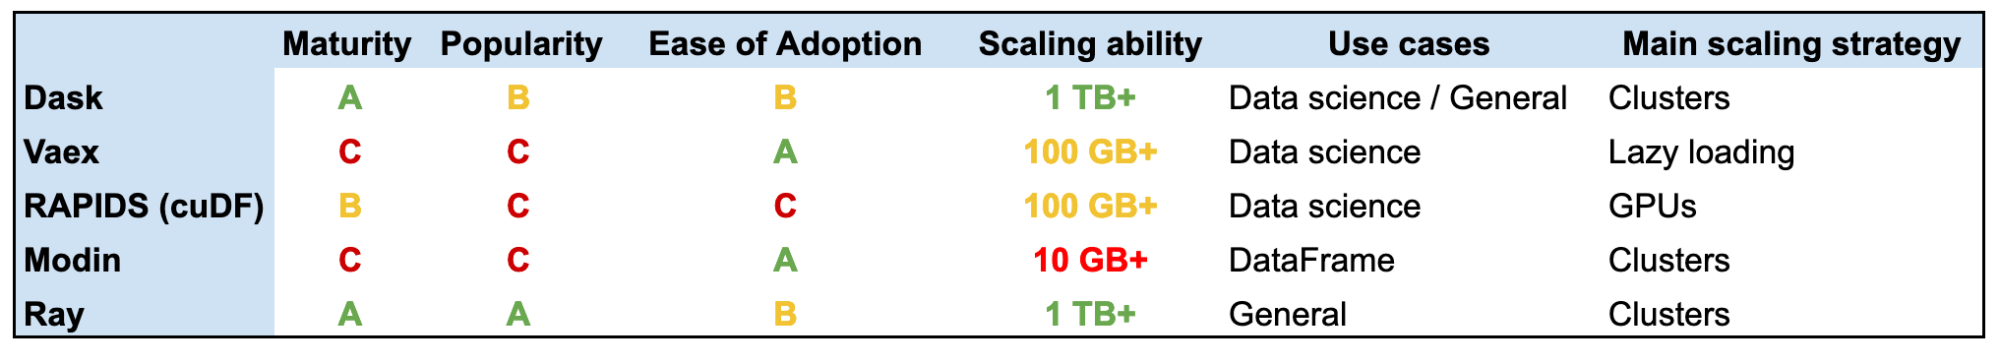

In [1]:
!pip install --upgrade pandas numpy > /dev/null

In [2]:
import pandas as pd
import numpy as np
print(pd.__version__)
print(np.__version__)

1.4.2
1.22.4


# The Data

In [3]:
!ls -GFlash --color /media/robmulla/moardata/reddit_place2/combined*

16G -rw-rw-r-- 1 robmulla 16G Apr 19 11:11 /media/robmulla/moardata/reddit_place2/combined_v1.parquet


# The Tests:
1. Reading in the file. Speed comparison
2. Compute metrics of a column: (mean, std)
3. Finding the unique count of a column
4. Cumulative sum of a column
5. Groupby Aggregation

# Pandas

In [4]:
%%time
df = pd.read_parquet('/media/robmulla/moardata/reddit_place2/combined_v1.parquet')

CPU times: user 1min 27s, sys: 31 s, total: 1min 58s
Wall time: 1min 46s


In [5]:
df.shape

(160353104, 5)

In [6]:
df.head()

,timestamp,user_id,pixel_color,x,y
0,2022-04-04 00:53:51.577000+00:00,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...,#00CCC0,826,1048
1,2022-04-04 00:53:53.758000+00:00,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...,#94B3FF,583,1031
2,2022-04-04 00:53:54.685000+00:00,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...,#6A5CFF,1873,558
3,2022-04-04 00:54:57.541000+00:00,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...,#009EAA,1627,255
4,2022-04-04 00:55:16.307000+00:00,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...,#94B3FF,49,1478


In [12]:
%%time
_ = df['x'].mean()
print(f'The mean value {_}')

The mean value 798.2981503058401
CPU times: user 89.2 ms, sys: 426 µs, total: 89.6 ms
Wall time: 88 ms


In [13]:
%%time
_ = df['x'].std()
print(f'The standard deviation {_}')

The standard deviation 613.3787908829692
CPU times: user 350 ms, sys: 777 ms, total: 1.13 s
Wall time: 1.13 s


In [14]:
%%time
_ = df['user_id'].unique()
len(_)

CPU times: user 1min 14s, sys: 3.07 s, total: 1min 17s
Wall time: 1min 17s


10381163

In [15]:
%%time
_ = df['y'].cumsum()

CPU times: user 536 ms, sys: 551 ms, total: 1.09 s
Wall time: 1.09 s


In [16]:
%%time
_ = df.groupby('user_id')['x'].mean()

CPU times: user 1min 58s, sys: 3.85 s, total: 2min 2s
Wall time: 2min 2s


## Pandas Summary Results
- Read Parquet: 1min 46s
- Mean(x): 88 ms
- Std(x): 1.13 s
- Unique ids: 1min 17s
- Cumsum(y): 1.09 s
- Groupby mean: 2min 2s

# Ray
A low-level framework for parallelizing Python code across processors or clusters.

In [1]:
!pip install ray > /dev/null

In [1]:
import ray
print('Ray Version', ray.__version__)

Ray Version 1.11.0


In [2]:
%%time
ray_dataset = ray.data.read_parquet('/media/robmulla/moardata/reddit_place2/combined_v1.parquet')

2022-05-30 15:19:18,508	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8265


CPU times: user 408 ms, sys: 81.3 ms, total: 490 ms
Wall time: 4.85 s


In [3]:
ray_dataset.schema()

timestamp: timestamp[us, tz=UTC]
user_id: string
pixel_color: string
x: int32
y: int32
__index_level_0__: int64
-- schema metadata --
pandas: '{"index_columns": ["__index_level_0__"], "column_indexes": [{"na' + 906

In [ ]:
%%time
from ray.data.aggregate import Max, Mean
ray_dataset.aggregate(Mean("x"))

In [ ]:
%%time
ray_dataset.std("x")

In [13]:
# ray_dataset.unqiue('user_id')

In [5]:
# ray_dataset.groupby('user_id').mean('x')

## Ray Results
- Nothing worked.

# Dask

Dask: a low-level scheduler and a high-level partial Pandas replacement, geared toward running code on compute clusters.

In [1]:
# install
!pip install dask > /dev/null

In [2]:
import dask
import dask.dataframe as dd
print(dask.__version__)

2022.01.1


In [3]:
%%time
df = dd.read_parquet('/media/robmulla/moardata/reddit_place2/combined_v1.parquet')

CPU times: user 26.1 ms, sys: 0 ns, total: 26.1 ms
Wall time: 34.2 ms


In [4]:
%%time
df.head()

CPU times: user 2min 8s, sys: 37.6 s, total: 2min 46s
Wall time: 2min 43s


,timestamp,user_id,pixel_color,x,y
0,2022-04-04 00:53:51.577000+00:00,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...,#00CCC0,826,1048
1,2022-04-04 00:53:53.758000+00:00,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...,#94B3FF,583,1031
2,2022-04-04 00:53:54.685000+00:00,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...,#6A5CFF,1873,558
3,2022-04-04 00:54:57.541000+00:00,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...,#009EAA,1627,255
4,2022-04-04 00:55:16.307000+00:00,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...,#94B3FF,49,1478


In [5]:
%%time
_ = df['x'].mean().compute()
print(f'The mean value {_}')

The mean value 798.2981503058401
CPU times: user 3.28 s, sys: 2.77 s, total: 6.05 s
Wall time: 5.72 s


In [7]:
%%time
_ = df['x'].std().compute()
print(f'The std value {_}')

The std value 613.3787908829692
CPU times: user 3.89 s, sys: 1.96 s, total: 5.86 s
Wall time: 5.59 s


In [8]:
%%time
_ = df['user_id'].unique()
len(_)

CPU times: user 3min 40s, sys: 33.6 s, total: 4min 14s
Wall time: 4min 12s


10381163

In [9]:
%%time
_ = df['y'].cumsum().compute()

CPU times: user 4.02 s, sys: 3.58 s, total: 7.6 s
Wall time: 7.26 s


In [12]:
%%time
_ = df.groupby('user_id')['x'].mean().compute()

CPU times: user 8min 1s, sys: 1min 3s, total: 9min 5s
Wall time: 6min 48s


## Dask Summary:
- Read Parquet (and head): 2min 43s
- Mean(x): 5.72 s
- Std(x): 5.59 s
- Unique ids: 4min 12s
- Cumsum(y): 7.26 s
- Groupby mean: 6min 48s

# Modin
A drop-in replacement for Pandas, powered by either Dask or Ray.

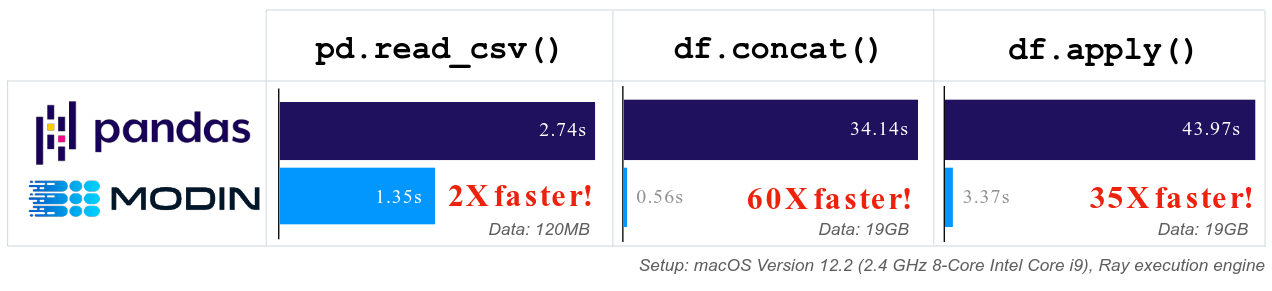

In [1]:
!pip install modin > /dev/null

In [2]:
import modin
print(modin.__version__)

0.14.0


In [3]:
import os
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
import modin.pandas as pd
import ray
ray.init()

2022-05-30 15:43:48,235	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.153',
 'raylet_ip_address': '192.168.1.153',
 'redis_address': None,
 'object_store_address': '/tmp/ray/session_2022-05-30_15-43-46_101786_1390186/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-05-30_15-43-46_101786_1390186/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-05-30_15-43-46_101786_1390186',
 'metrics_export_port': 58449,
 'gcs_address': '192.168.1.153:57676',
 'address': '192.168.1.153:57676',
 'node_id': '1f4a38f812d875fb24b090ce72f999fe9d567a539c03a98dacd62769'}

In [4]:
%%time
df = pd.read_parquet('/media/robmulla/moardata/reddit_place2/combined_v1.parquet')

CPU times: user 2.82 s, sys: 551 ms, total: 3.37 s
Wall time: 3min 45s


In [5]:
%%time
df.head()

CPU times: user 3.33 ms, sys: 0 ns, total: 3.33 ms
Wall time: 2.71 ms


2022-05-30 15:48:35,200	WARNING worker.py:1326 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/robmulla/anaconda3/envs/kaggle2/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1390186/1873162230.py", line 1, in <module>
    get_ipython().run_cell_magic('time', '', 'df.head()\n')
  File "/home/robmulla/anaconda3/envs/kaggle2/lib/python3.8/site-packages/IPython/core/displayhook.py", line 262, in __call__
    format_dict, md_dict = self.compute_format_data(result)
  File "/home/robmulla/anaconda3/envs/kaggle2/lib/python3.8/site-packages/IPython/core/displayhook.py", line 151, in compute_format_data
    return self.shell.display_formatter.format(result)
  File "/home/robmulla/anaconda3/envs/kaggle2/lib/python3.8/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "<decorator-gen-3>", line 2, in __call__
  File "/home/robmulla/anaconda3/envs/kaggle2/lib/python3.8/site-packages/IPy

TypeError: object of type 'NoneType' has no len()

In [6]:
%%time
_ = df['x'].mean()
print(f'The mean value {_}')

The mean value 798.2981503058401
CPU times: user 126 ms, sys: 35.4 ms, total: 162 ms
Wall time: 526 ms


In [7]:
%%time
_ = df['x'].std()
print(f'The std value {_}')

The std value 613.3787908829692
CPU times: user 48.4 ms, sys: 8.72 ms, total: 57.2 ms
Wall time: 5.75 s


In [8]:
%%time
_ = df['user_id'].unique()

CPU times: user 4.18 s, sys: 1.1 s, total: 5.28 s
Wall time: 2min 47s


In [9]:
%%time
_ = df['y'].cumsum()

CPU times: user 159 ms, sys: 135 ms, total: 293 ms
Wall time: 276 ms


In [10]:
%%time
_ = df.groupby('user_id')['x'].mean()

CPU times: user 4.78 s, sys: 1.11 s, total: 5.89 s
Wall time: 4min 44s


## Modin Results
- Read Parquet (and head):3min 45s
- Mean(x): 526 ms
- Std(x): 5.75 s
- Unique ids: 2min 47s
- Cumsum(y): 276 ms
- Groupby mean: 4min 44s

# Vaex
A partial Pandas replacement that uses lazy evaluation and memory mapping to allow developers to work with large datasets on standard machines.

In [1]:
!pip install vaex > /dev/null

In [1]:
import vaex
vaex.__version__

{'vaex': '4.9.1',
 'vaex-core': '4.9.1',
 'vaex-viz': '0.5.1',
 'vaex-hdf5': '0.12.1',
 'vaex-server': '0.8.1',
 'vaex-astro': '0.9.1',
 'vaex-jupyter': '0.7.0',
 'vaex-ml': '0.17.0'}

In [19]:
%%time
df = vaex.open('/media/robmulla/moardata/reddit_place2/combined_v1.parquet')

CPU times: user 4.15 ms, sys: 0 ns, total: 4.15 ms
Wall time: 3.2 ms


In [20]:
%%time
df.head()

CPU times: user 683 µs, sys: 235 µs, total: 918 µs
Wall time: 886 µs


#,timestamp,user_id,pixel_color,x,y
0,2022-04-04 00:53:51.577000+00:00,'ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8al...,#00CCC0,826,1048
1,2022-04-04 00:53:53.758000+00:00,'6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3dM...,#94B3FF,583,1031
2,2022-04-04 00:53:54.685000+00:00,'O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWbN...,#6A5CFF,1873,558
3,2022-04-04 00:54:57.541000+00:00,'tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQEL...,#009EAA,1627,255
4,2022-04-04 00:55:16.307000+00:00,'OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUrJ...,#94B3FF,49,1478
5,2022-04-04 00:55:20.640000+00:00,'A0HdtcPvI7ipKivvXNVZDa3gkcjGXFjNxF5tca5QXazENCG...,#E4ABFF,408,1863
6,2022-04-04 00:55:34.898000+00:00,'1U4LPuB22P6Yf7eRhKz6zU1dFMK5wXIzsNVPUNhP7eHIwGu...,#94B3FF,111,1582
7,2022-04-04 00:55:40.375000+00:00,'0AGoMGF50j0DJDc+704SwMylU90YDILDIgo8WOetgpiEWGE...,#6A5CFF,1334,1840
8,2022-04-04 00:55:57.168000+00:00,'tPcrtm7OtEmSThdRSWmB7jmTF9lUVZ1pltNv1oKqPY9bom/...,#6A5CFF,1908,1854
9,2022-04-04 00:56:07.430000+00:00,'7wfv1Tew3St1xYXQrTy7EF4LYwuuzxb0TXOxzxGBXriim81...,#009EAA,1504,1722


In [4]:
%%time
_ = df['x'].mean()
print(f'The mean value {_}')

The mean value 798.2981503058401
CPU times: user 4.1 s, sys: 461 ms, total: 4.56 s
Wall time: 673 ms


In [5]:
%%time
_ = df['x'].std()
print(f'The std value {_}')

The std value 613.3787889703823
CPU times: user 26.8 s, sys: 1.79 s, total: 28.6 s
Wall time: 4.33 s


In [8]:
%%time
_ = df['user_id'].unique()

CPU times: user 6min 50s, sys: 51.9 s, total: 7min 42s
Wall time: 29.5 s


In [10]:
%%time
_ = df['y'].cumsum()

AttributeError: 'Expression' object has no attribute 'cumsum'

In [13]:
%%time
_ = df.groupby(df.user_id, agg={'x_mean': [vaex.agg.mean('x')]})

CPU times: user 15min 9s, sys: 2min 29s, total: 17min 39s
Wall time: 1min 22s


## Vaex Results
- Read Parquet (and head): 17 sec
- Mean(x): 673 ms
- Std(x): 4.33 s
- Unique ids: 29.5 s
- Cumsum(y): N/A
- Groupby mean: 1min 22s


# Results Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tests = ['read','mean','std','unique','cumsum','groupby']
results = {'pandas': [60 + 46, 0.088, 1.13, 60+17, 1.09, 120 + 2],
          'dask':[120+43, 5.72, 5.59, 240+12, 7.26, 6*60 + 48],
           'modin':[3*60+45, 0.526, 5.75, 120+47, 0.276, 480+44],
           'vaex':[17, 0.673, 4.33, 29.5, np.nan, 60 + 22],
          }

results_df = pd.DataFrame(data=results, index=tests)

In [2]:
results_df

,pandas,dask,modin,vaex
read,106.000,163.00,225.000,17.000
mean,0.088,5.72,0.526,0.673
std,1.130,5.59,5.750,4.330
unique,77.000,252.00,167.000,29.500
cumsum,1.090,7.26,0.276,NaN
groupby,122.000,408.00,524.000,82.000


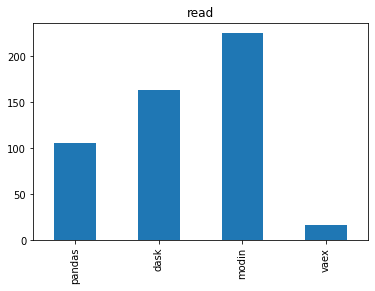

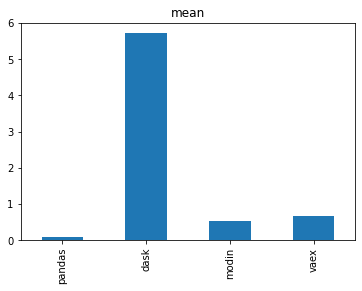

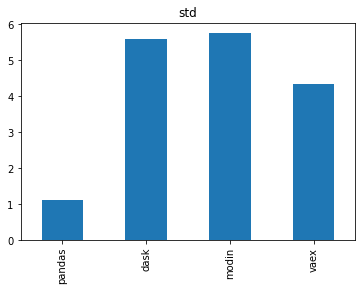

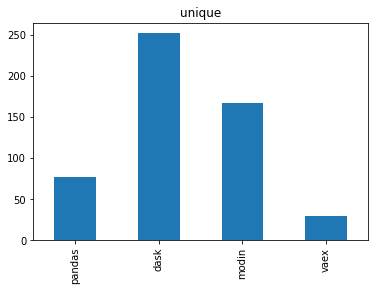

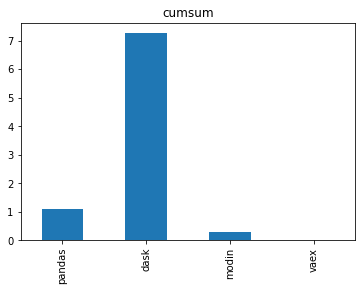

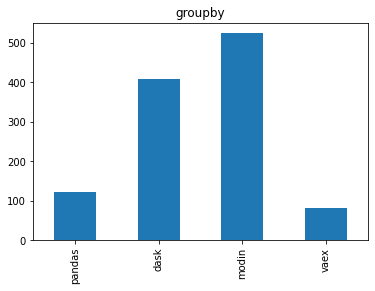

In [3]:
for test in results_df.index:
    results_df.loc[test].plot(kind='bar', title=test)
    plt.show()